<h1>The purpose of this notebook is to check which features might be best, i.e., they separate better the data. This is in order to avoid to iterate over all combinations of the features and saving time.
Each point on a plot represents a <b>segment</b>.
<br>
Take these results very carefully for two reasons: we have a total of around 1400 segments, less than 10% of the data we will process, and visual inspection is ok but is no matenatical proof
</h1>

In [3]:
import os, pandas as pd, numpy as np
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from sod.evaluation.datasets import oneminutewindows

dataframe = oneminutewindows(os.path.join(os.getcwd(), '..', '..', 'tmp', 'datasets', 'oneminutewindows.hdf'))

Opening /Users/riccardo/work/gfz/projects/sources/python/sod/tmp/datasets/oneminutewindows.hdf

                                instances
ok                              1,003,203
outl. (wrong inv. file)             4,356
outl. (cha. resp. acc <-> vel)  1,181,439
outl. (gain X100 or X0.01)      1,003,203
outl. (gain X10 or X0.1)        1,003,203
outl. (gain X2 or X0.5)         1,003,203
total                           5,198,607

Normalizing numeric columns (floats only)
(only good instances - no outliers - taken into account)
                  min median   max      NAs ids outside[1-99]%
psd@0.05sec      0.00   0.97  1.13    2,652             10,647
psd@0.1sec       0.00   0.97  1.12        0             10,890
psd@0.2sec       0.00   0.97  1.10        4             10,938
psd@0.5sec       0.00   0.97  1.10       16             11,261
psd@1sec         0.00   0.97  1.10       40             11,464
psd@2sec         0.00   0.97  1.09      106             10,982
psd@3sec         0.00   0.9

In [4]:
import matplotlib.pyplot as plt
from sod.evaluation import is_outlier
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

PLOT_RATIO = 0.2  # there is too much data, show only this ratio
LOW_SNR = False

def plot(df, col_x, col_y, col_z=None, axis_lim=None):
    '''axis_lim is the quantile of data to be shown on the axis: 0.95 will display the axis min and max
    at 0.05 quantile of the data distribution and 0.95 quantile, respectuvely'''
    if LOW_SNR:
        df = df[df['snr'] > 3]
    is_outl = is_outlier(df)
    df = df[:int(len(df) * PLOT_RATIO)]
    # df = df[(~df['low_snr']) & ~(df['saturated'])]
    df_ok = df[~is_outl]
    df_no = df[is_outl]
    
    if axis_lim is None:
        minx, maxx = (df[col_x]).min(), (df[col_x]).max()
        miny, maxy = (df[col_y]).min(), (df[col_y]).max()
        minz, maxz = (None, None)
        if col_z is not None:
            miny, maxy = (df[col_z]).min(), (df[col_z]).max()
    else:
        minx, maxx = df[col_x].quantile([1-axis_lim, axis_lim])
        miny, maxy = df[col_y].quantile([1-axis_lim, axis_lim])
        minz, maxz = (None, None)
        if col_z is not None:
            minz, maxz = df[col_z].quantile([1-axis_lim, axis_lim])

    
    # divide the dataframe in bins. Take PLOT_RATIO randomly points for each bin
    indices = set()
    for c in [col_x, col_y] + ([] if col_z is None else [col_z]):
        bins = pd.cut(df[c], 10)
        for _, df_ in df.groupby(bins):
            if df_.empty:
                continue
            num = int(len(df_) * PLOT_RATIO)
            if num < 1:
                num = 1
            indices |= set(df_.sample(num).index.values)
    
    l = len(df)
    df = df.loc[list(indices), : ]
    print("%d -> %d " % (len(df), l))
    fig = plt.figure(figsize=(15, 15))

    def newaxes(index):
        row, col = 3, 3
        if col_z is not None:
            ax = fig.add_subplot(row, col, index, projection='3d')
        else:
            ax = fig.add_subplot(row, col, index)
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.set_xlabel(col_x)
        ax.set_ylabel(col_y)
        if col_z is not None:
            ax.set_zlabel(col_z)
            ax.set_zlim(minz, maxz)
        ax.grid(True)
        return ax
    
    def scatter(ax, df, color):
        kwargs = {'edgecolors': 'none', 's': 81}
        if col_z is None:
            ax.scatter(df[col_x], df[col_y], color=color, **kwargs)
        else:
            ax.scatter(df[col_x], df[col_y], df[col_z], color=color, **kwargs)
        
    alpha = 0.1
    
    ax = newaxes(1)
    scatter(ax, df_ok, [0, 0.1, 0.75, alpha])
    ax.set_title('GOOD: %d segs' % len(df_ok))
    
    ax = newaxes(2)
    df_no_ = df_no[df_no['modified'].str.contains('CHARESP')]
    scatter(ax, df_no_, [0.75, 0.1, 0, alpha])
    ax.set_title('BAD (CH.RESP. SWITCH ACC<->VEL): %d segs' % len(df_no_))

    ax = newaxes(3)
    df_no_ = df_no[df_no['modified'].str.contains('INVFILE:')]
    scatter(ax, df_no_, [0, 0.75, 0.1, alpha])
    ax.set_title('BAD (WRONG INVENTORY): %d segs' % len(df_no_))
    
    color = [0.75, 0.5, 0, alpha]

    for i, label in enumerate([
        'STAGEGAIN:X100.0',
        'STAGEGAIN:X10.0',
        'STAGEGAIN:X2.0',
        'STAGEGAIN:X0.01',
        'STAGEGAIN:X0.1',
        'STAGEGAIN:X0.5'
    ], 4):
        ax = newaxes(i)
        df_no_ = df_no[df_no['modified'].str.contains(label)]
        scatter(ax, df_no_, color)
        ax.set_title('BAD (%s): %d segs' % (label, len(df_no_)))
    
#     ax = newaxes(5)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X10.0')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAINx5): %d segs' % len(df_no_))
    
#     ax = newaxes(6)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X2.0')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAINx2): %d segs' % len(df_no_))
    
#     ax = newaxes(7)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.1')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/10): %d segs' % len(df_no_))
    
#     ax = newaxes(8)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.2')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/5): %d segs' % len(df_no_))
    
#     ax = newaxes(9)
#     df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.5')]
#     scatter(ax, df_no_, color)
#     ax.set_title('BAD (GAIN/2): %d segs' % len(df_no_))
    
    space = .4 if col_z is not None else .25
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=space, hspace=space)
    

<h3>First try: psd@2sec, psd@5sec, which were the best parameters with the pgspgv dataset</h3>

/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


374118 -> 1039721 
5198607


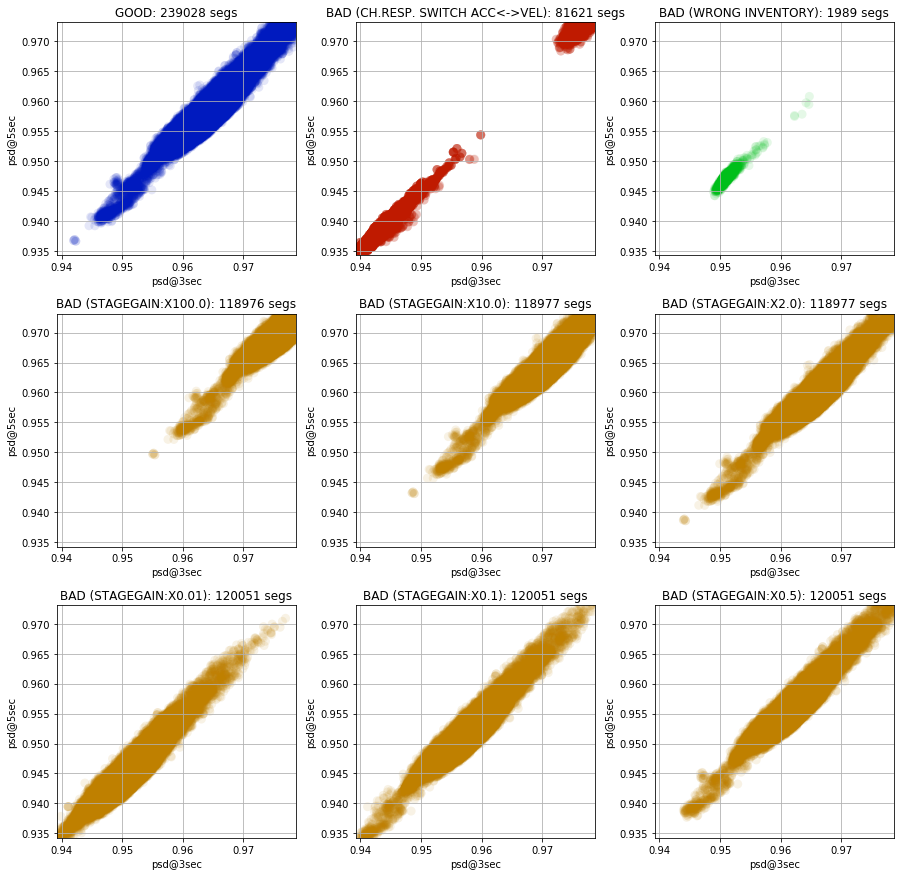

In [5]:
plot(dataframe, 'psd@3sec', 'psd@5sec', axis_lim=.945)
print(len(dataframe))

<h3>Second try: only noisy windows</h3>

1732869


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


124828 -> 346573 


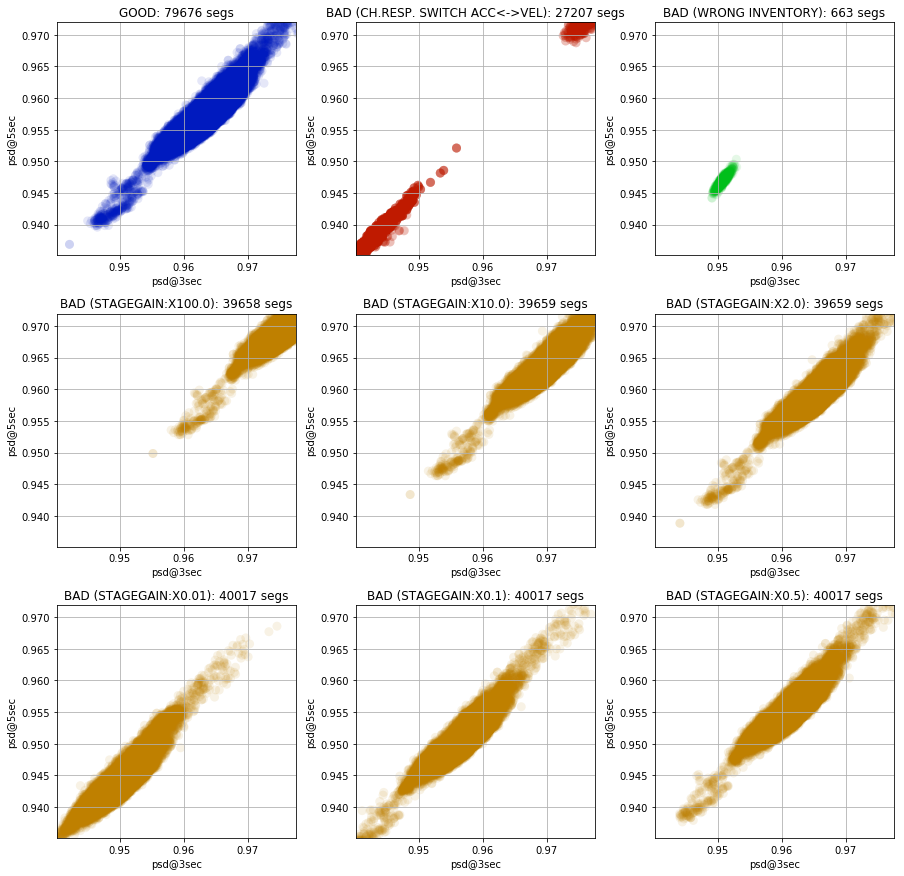

In [6]:
dfr = dataframe[dataframe['window_type'].str.match('^n$')]
print(len(dfr))
plot(dfr, 'psd@3sec', 'psd@5sec', axis_lim=.94)  # with delta_pgv does not change a lot

<h3>Mixed windows
    <!-- <ul>
        <li>At low periods we have more antropic noise, but apparently if we have a really wrong inventory (first row of plots) psd@0.1sec seem to perform as psd@10sec for good vs bad data (plots on the first row).
        <li>But, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue), and in this case psd@10sec performs better
    </ul> -->
</h3>

1732869


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


124540 -> 346573 


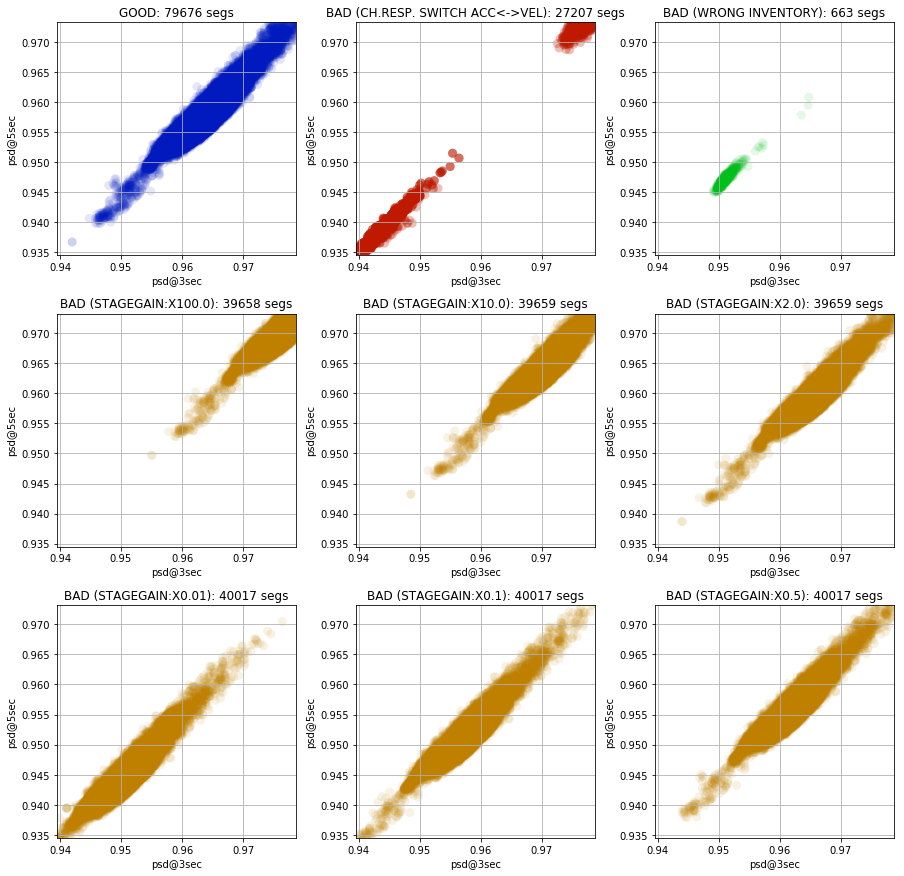

In [7]:
dfr = dataframe[dataframe['window_type'].str.match('^ns$')]
print(len(dfr))
plot(dfr, 'psd@3sec', 'psd@5sec', axis_lim=.945)  # with delta_pgv does not change a lot

<h3>Only signal windows</h3>

1732869


/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/riccardo/work/gfz/projects/sources/python/sod/.env/sod/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


124562 -> 346573 


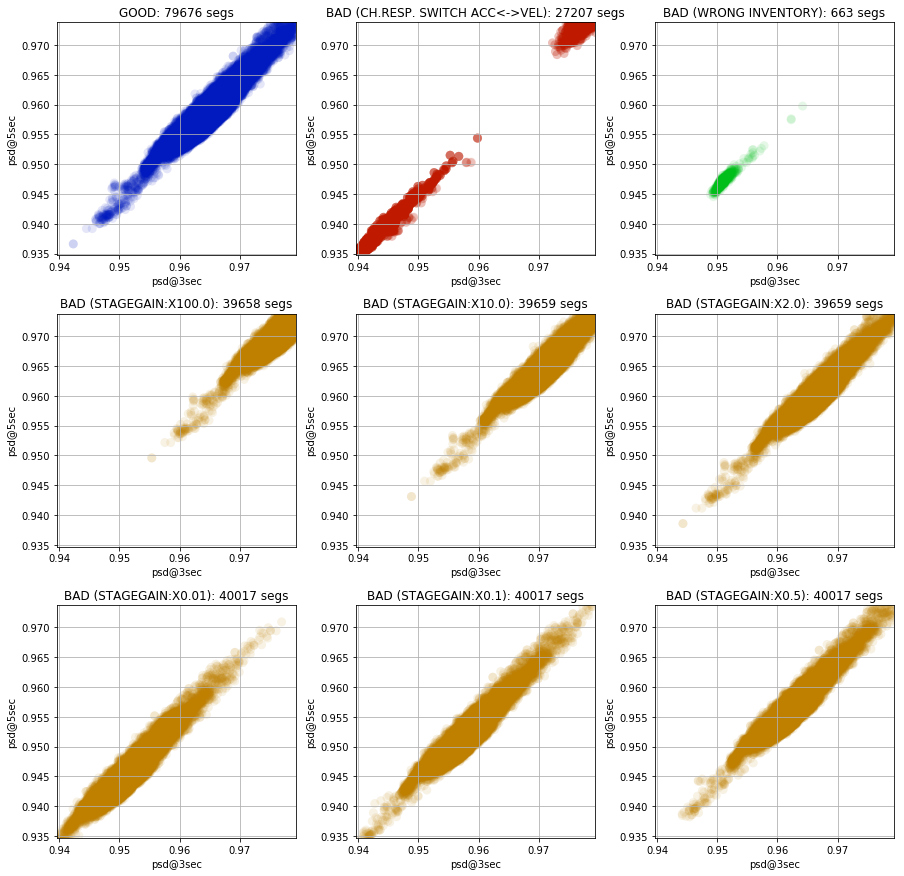

In [8]:
dfr = dataframe[dataframe['window_type'].str.match('^s$')]
print(len(dfr))
plot(dfr, 'psd@3sec', 'psd@5sec', axis_lim=.945)  # with delta_pgv does not change a lot